In [1]:
from process_bigraph import Composite, pp
import numpy as np

from bsp import app_registrar
from bsp.processes.simple_membrane_process import SimpleMembraneProcess


test_state_init_fp = '../test-membrane-initial.json'
oblate = "../fixtures/sample_meshes/oblate.ply"
prolate = "../fixtures/sample_meshes/prolate.ply"

membrane_config = {
    'characteristic_time_step': 1,
    'geometry': {
        'type': 'icosphere',
        'parameters': {
            'radius': 1.0,
            'subdivision': 2
        }
    },
    'tension_model': {
        'modulus': 0.1,
        'preferred_area': 12.4866
    },
    'osmotic_model': {
        'preferred_volume': 0.7 * 3.14 * 4 / 3,
        'reservoir_volume': 1,
        'strength': 0.02,
        'volume': 2.9
    },
    'parameters': {
        'bending': {
            'Kbc': 8.22e-05
        },
        'damping': 0.05
    },
    'tolerance': 1e-11,
    'console_output': False
}




In [2]:
input_composite_state = {
    'membrane': {
        '_type': 'process',
        'address': 'local:simple-membrane-process',
        'config': membrane_config,
        'inputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'osmotic_strength': ['osmotic_strength_store'],
            'duration': ['duration_store']
        },
        'outputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'net_forces': ['net_forces_store'],
            'duration': ['duration_store']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'geometry': 'GeometryType',
                'velocities': 'VelocitiesType',
                'protein_density': 'ProteinDensityType',
                'volume': 'float',
                'preferred_volume': 'float',
                'reservoir_volume': 'float',
                'surface_area': 'float',
                'net_forces': 'MechanicalForcesType',
            }
        },
        'inputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'net_forces': ['net_forces_store'],
        }
    }
}

In [3]:
sim = Composite(config={'state': input_composite_state}, core=app_registrar.core)

In [4]:
# sim.state['membrane']['instance'].initial_state()

In [5]:
total_time = 10
sim.run(total_time)

Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0


In [6]:
sim_results = sim.gather_results()[('emitter',)]

In [39]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialize scatter plot (we'll update this later)
sc = ax.scatter([], [], [], c='blue', marker='o')

# Set axis limits (adjust based on your data)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Membrane Vertex Animation")

def get_times(sim):
    return [t for t in range(
        len(sim.gather_results()[('emitter',)])
    )]

def update(frame):
    # Get the vertex positions for the current timestep
    vertices = sim_results[frame]['geometry']['vertices']

    # Extract x, y, z coordinates
    x, y, z = vertices[::3], vertices[1::3], vertices[2::3]

    # Update scatter plot data
    sc._offsets3d = (x, y, z)

    return sc,


fig.colorbar(sc, ax=ax, label='Intensity')
ani = animation.FuncAnimation(fig, update, len(get_times(sim)), blit=False)
HTML(ani.to_jshtml())

ValueError: shapes (4,4) and (4,54,3) not aligned: 4 (dim 1) != 54 (dim 1)

ValueError: shapes (4,4) and (4,54,3) not aligned: 4 (dim 1) != 54 (dim 1)

<Figure size 800x600 with 2 Axes>

In [32]:
def get_3d_slice_animation(sim, interval=200) -> animation.FuncAnimation:
        # Create a figure for 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Set labels for axes
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        sc = None

        num_timepoints = len(get_times(sim))

        def update(frame: int):
            """ Update function for animation """
            # Define a mask to display the volume (use 'region_mask' channel)
            mask = get_vertices(sim, frame)
            z, y, x = mask[::3], mask[1::3], mask[2::3]

            volume = get_vertices(sim, frame)
            intensities = volume[z, y, x]

            # Initialize the scatter plot with empty data
            scatter = ax.scatter(x, y, z, c=intensities, cmap='viridis')
            ax.set_title(f"Time Index: {frame}")
            sc = scatter
            return scatter,

        # Create the animation
        fig.colorbar(sc, ax=ax, label='Intensity')
        ani = animation.FuncAnimation(fig, update, num_timepoints, interval=interval, blit=False)

        return ani

IndexError: arrays used as indices must be of integer (or boolean) type

Error in callback <function _draw_all_if_interactive at 0x308f92680> (for post_execute), with arguments args (),kwargs {}:


IndexError: arrays used as indices must be of integer (or boolean) type

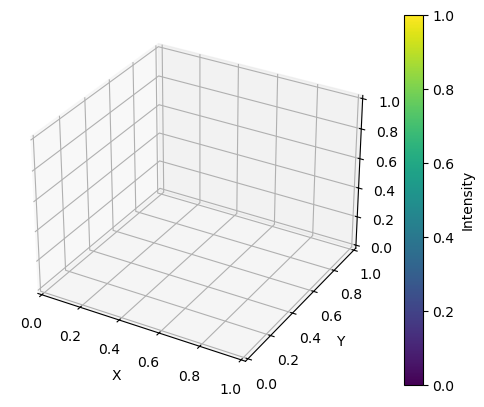

In [33]:
ani = get_3d_slice_animation(sim)

HTML(ani.to_jshtml())